# RNN com LSTM

In [33]:
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from statsmodels.stats.diagnostic import acorr_ljungbox
from tqdm import tqdm

import metrics
import models

In [34]:
def set_seed(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seed(0)


## Carregando os dados

In [35]:
us_change = pd.read_csv('us_change.csv')

In [36]:
# Convert the 'Quarter' column to datetime format using quarter ending
def parse_quarter(quarter_str):
    year, quarter = quarter_str.split(' ')
    month = int(quarter[1]) * 3
    return pd.Timestamp(f'{year}-{month:02d}-01')

us_change['Quarter'] = us_change['Quarter'].apply(parse_quarter)
us_change['QuarterDummy'] = us_change['Quarter'].dt.quarter

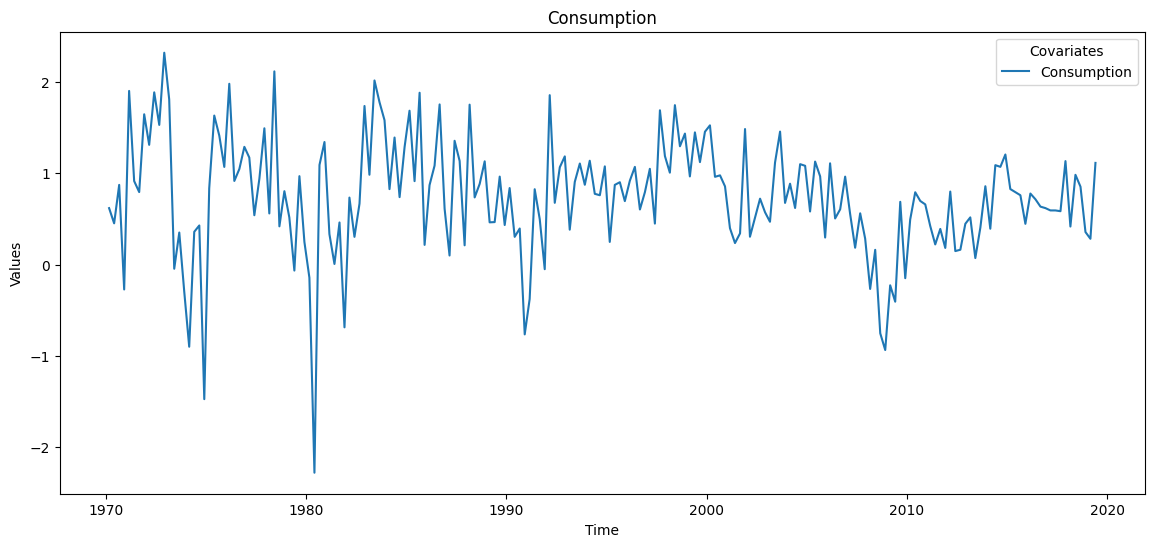

In [37]:
# Plot all covariates as time series

plt.figure(figsize=(14, 6))
sns.lineplot(data=us_change, x='Quarter', y='Consumption', label='Consumption')
plt.title('Consumption')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend(title='Covariates')
plt.show()

## Funções auxiliares

In [38]:
TEST_SIZE = 12

In [39]:
# Dataset functions

def create_dataset(df: pd.DataFrame, window_size: int, X_columns: list, y_column: str) -> tuple[np.ndarray, np.ndarray]:
    """
    Create the dataset with the specified window size
    """
    X, y = [], []
    for i in range(len(df) - window_size):
        X.append(df.iloc[i:(i + window_size)][X_columns])
        y.append(df.iloc[i + window_size][y_column])
    return np.array(X), np.array(y)

def split_dataset(X: np.ndarray, y: np.ndarray, test_size: int) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Split the dataset into training and testing sets
    """
    train_size = X.shape[0] - test_size
    X_train, X_test, y_train, y_test = X[:train_size], X[train_size:], y[:train_size], y[train_size:]
    return X_train, X_test, y_train, y_test

In [40]:
# Plot functions

def plot_lstm_loss(model: models.LSTM) -> None:
    """
    Plot the loss of the LSTM model
    """
    plt.figure(figsize=(14, 6))
    plt.plot(model.model.history.history['loss'], label='Training Loss')
    plt.title('LSTM Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_resid(resid: np.ndarray) -> None:
    """
    Plot the residuals
    """
    plt.figure(figsize=(14, 6))
    plt.stem(resid)
    plt.title('Residuals')
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.show()

In [41]:
# Model functions

def get_metrics(y_true: np.ndarray, y_pred: np.ndarray, y_train: np.ndarray, n_params) -> dict[str, float]:
    """
    Get the metrics for the model
    """
    return {
        'MAE': metrics.mae(y_true, y_pred),
        'MSE': metrics.mse(y_true, y_pred),
        'RMSE': metrics.rmse(y_true, y_pred),
        'MAPE': metrics.mape(y_true, y_pred),
        'SMAPE': metrics.smape(y_true, y_pred),
        'R2': metrics.r2(y_true, y_pred),
        'MASE': metrics.mase(y_true, y_pred, y_train),
        'AIC': metrics.aic(y_true, y_pred, n_params),
        'BIC': metrics.bic(y_true, y_pred, n_params),
    }

## LSTM na própria série temporal

Nesse primeiro caso vamos utilizar a própria série temporal para prever o próximo valor.

### Apresentando o funcionamento

In [42]:
# Gerando dataset com janela de 5 observações
X, y = create_dataset(us_change, 5, ['Consumption'], 'Consumption')
X_train, X_test, y_train, y_test = split_dataset(X, y, TEST_SIZE)

Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.8680
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6286 
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4623 
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3840 
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3783 
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3710 
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3631 
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3650 
Epoch 9/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3653 
Epoch 10/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3616 


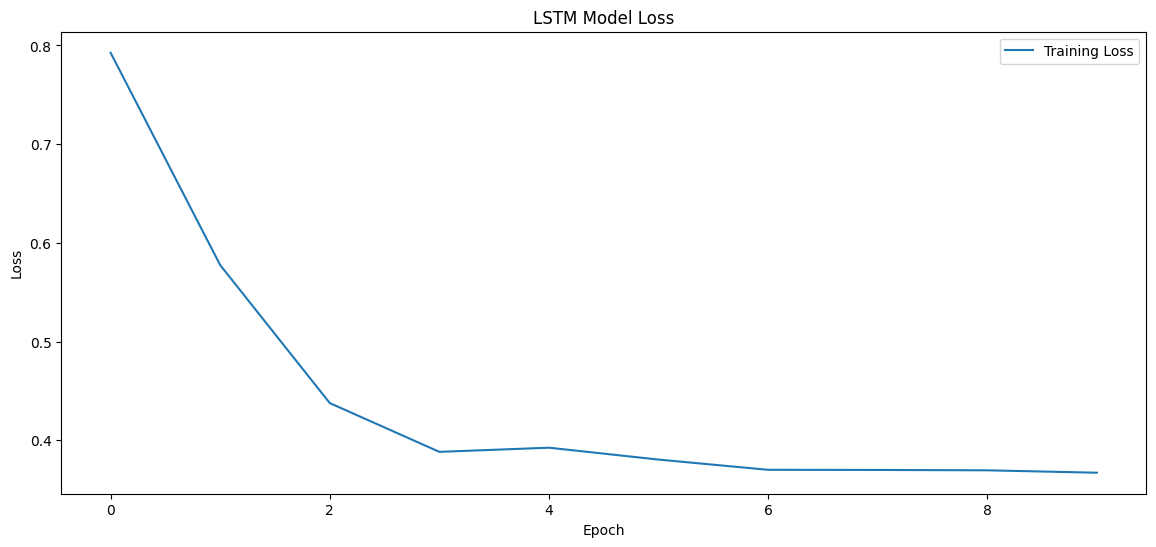

In [43]:
# Instanciando e treinando o modelo
lstm = models.LSTM((X_train.shape[1], X_train.shape[2]), 64)
lstm.fit(X_train, y_train)
plot_lstm_loss(lstm)

In [44]:
pred = lstm.predict_n_preds(X_test[0], TEST_SIZE).reshape(-1)
fitted = lstm.predict(X_train).reshape(-1)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


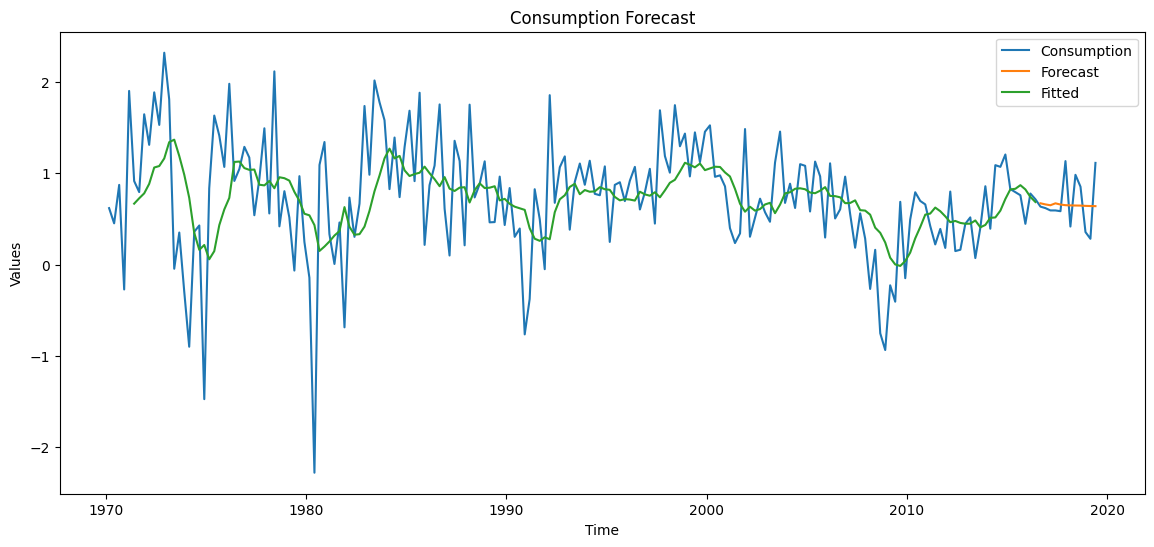

In [45]:
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(us_change['Quarter'], us_change['Consumption'], label='Consumption')
ax.plot(us_change['Quarter'].iloc[-len(pred):], pred, label='Forecast')
ax.plot(us_change['Quarter'].iloc[-len(fitted)-TEST_SIZE:-TEST_SIZE], fitted, label='Fitted')
ax.set_title('Consumption Forecast')
ax.set_xlabel('Time')
ax.set_ylabel('Values')
ax.legend()
plt.show()

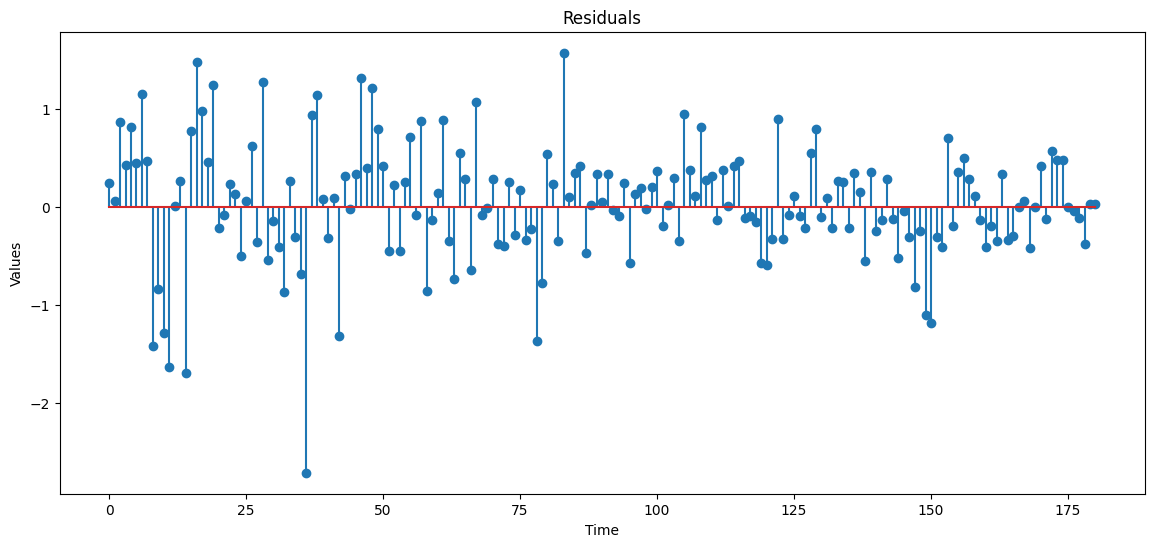

In [46]:
resid = y_train - fitted
plot_resid(resid)

In [47]:
get_metrics(y_train, fitted, y_train, lstm.model.count_params())

{'MAE': 0.4433731662416308,
 'MSE': 0.36436749440595995,
 'RMSE': 0.6036286063515877,
 'MAPE': 122.82555032087217,
 'SMAPE': 64.53368548598039,
 'R2': 0.14056849545562788,
 'MASE': 0.7961658155816839,
 'AIC': 33739.263789965546,
 'BIC': 87988.97193726522}

### Busca de hiperparâmetros

Vamos criar um conjunto de validação e tentar encontrar os melhores hiperparâmetros para o modelo:

* Window size
* Units

In [48]:
available_units = [8, 16, 32, 64, 128]
available_windows = [4, 8, 12, 16]

search_metrics = []

pbar = tqdm(total=len(available_units) * len(available_windows))
for units in available_units:
    for window in available_windows:
        X, y = create_dataset(us_change, window, ['Consumption'], 'Consumption')
        X_train, X_test, y_train, y_test = split_dataset(X, y, TEST_SIZE)

        lstm = models.LSTM((X_train.shape[1], X_train.shape[2]), units)
        lstm.fit(X_train, y_train, epochs=10, verbose=0)

        pred = lstm.predict(X_train, verbose=0).reshape(-1)

        temp_metrics = get_metrics(y_train, pred, y_train, lstm.model.count_params())

        search_metrics.append({
            'Units': units,
            'Window': window,
            **temp_metrics
        })
        pbar.update(1)
pbar.close()
search_metrics = pd.DataFrame(search_metrics)

100%|██████████| 20/20 [00:46<00:00,  2.31s/it]


In [49]:
search_metrics.sort_values('R2', ascending=False).head(10)

,Units,Window,MAE,MSE,RMSE,MAPE,SMAPE,R2,MASE,AIC,BIC
17,128,8,0.438530,0.352322,0.593567,138.261501,63.654175,0.173665,0.784572,133192.308542,345382.271727
19,128,16,0.421738,0.335100,0.578878,120.906133,62.289374,0.163511,0.764738,133192.134524,342315.396492
16,128,4,0.445799,0.361881,0.601566,131.176067,64.545017,0.156278,0.797124,133193.008099,346865.010054
1,8,8,0.443880,0.359815,0.599846,140.098476,64.227661,0.156090,0.794143,476.054626,1522.861414
8,32,4,0.445986,0.362937,0.602442,128.501962,64.686935,0.153817,0.797458,8585.538095,22635.107418
12,64,4,0.447696,0.363552,0.602952,122.272997,65.463043,0.152383,0.800516,33737.846229,88081.003649
18,128,12,0.438498,0.359167,0.599305,133.385455,64.681459,0.120403,0.784481,133199.829590,343874.068439
5,16,8,0.452583,0.375434,0.612727,136.227944,65.342330,0.119457,0.809714,2163.618450,5883.123420
15,64,16,0.436246,0.353798,0.594809,118.045278,63.550595,0.116836,0.791045,33745.365090,86931.642381
14,64,12,0.447838,0.369381,0.607767,133.048036,65.356381,0.095389,0.801190,33748.708800,87329.445730


In [50]:
best_model = search_metrics.sort_values('R2', ascending=False).iloc[0]
best_model

Units        128.000000
Window         8.000000
MAE            0.438530
MSE            0.352322
RMSE           0.593567
MAPE         138.261501
SMAPE         63.654175
R2             0.173665
MASE           0.784572
AIC       133192.308542
BIC       345382.271727
Name: 17, dtype: float64

Como esperado, o AIC ira sugerir modelos mais simples. Vamos utilizar a ordenação do RMSE para escolher o melhor modelo. Mesmo com AIC um pouco elevado, ainda está dentro de uma margem aceitável.

### Melhor modelo

In [51]:
# Gerando dataset com janela de 5 observações
X, y = create_dataset(us_change, int(best_model.Window), ['Consumption'], 'Consumption')
X_train, X_test, y_train, y_test = split_dataset(X, y, TEST_SIZE)

In [52]:
# Instanciando e treinando o modelo
lstm = models.LSTM((X_train.shape[1], X_train.shape[2]), int(best_model.Units))
lstm.fit(X_train, y_train)

Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.9436
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5134 
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4947 
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4435 
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4247 
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4159 
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4059 
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4030 
Epoch 9/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3951 
Epoch 10/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3871 


In [53]:
pred = lstm.predict_n_preds(X_test[0], TEST_SIZE).reshape(-1)
fitted = lstm.predict(X_train).reshape(-1)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  


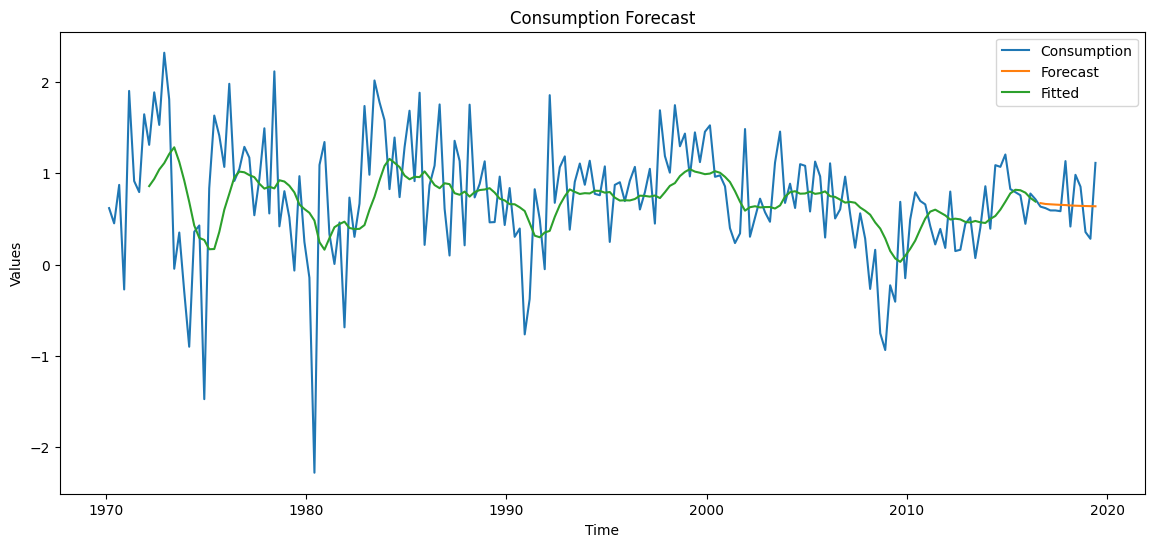

In [54]:
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(us_change['Quarter'], us_change['Consumption'], label='Consumption')
ax.plot(us_change['Quarter'].iloc[-len(pred):], pred, label='Forecast')
ax.plot(us_change['Quarter'].iloc[-len(fitted)-TEST_SIZE:-TEST_SIZE], fitted, label='Fitted')
ax.set_title('Consumption Forecast')
ax.set_xlabel('Time')
ax.set_ylabel('Values')
ax.legend()
plt.show()

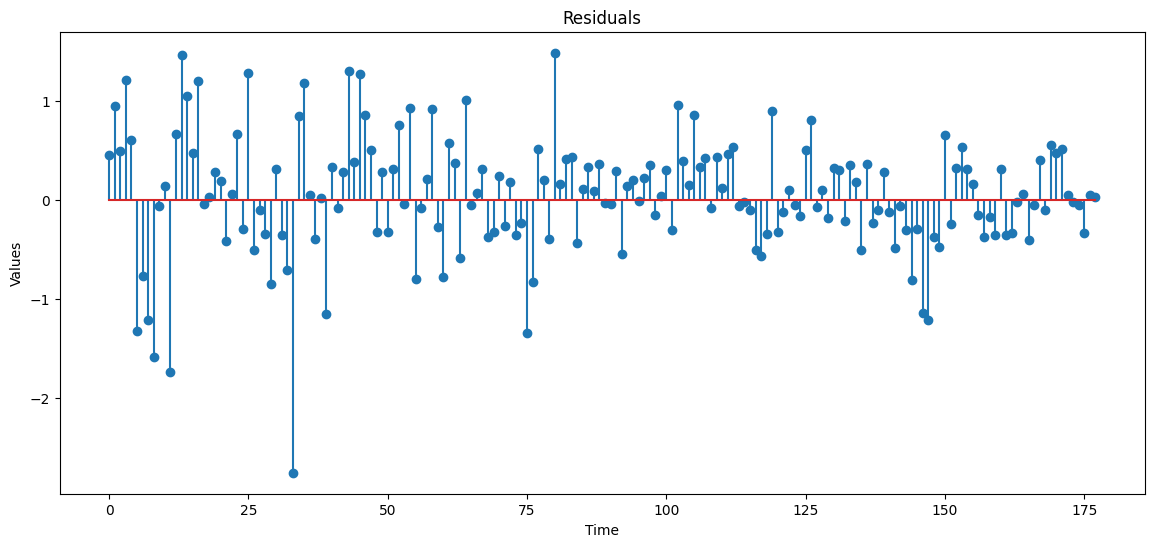

In [55]:
resid = y_train - fitted
plot_resid(resid)

In [56]:
results = get_metrics(y_train, fitted, y_train, lstm.model.count_params())
results

{'MAE': 0.445227691476492,
 'MSE': 0.3656109096646256,
 'RMSE': 0.6046576797367462,
 'MAPE': 130.8526811508893,
 'SMAPE': 64.40182662713566,
 'R2': 0.14249695806883922,
 'MASE': 0.7965550598237827,
 'AIC': 133198.89896330537,
 'BIC': 345388.8621487343}

## LSTM com covariáveis

### Apresentando o funcionamento

In [57]:
X, y = create_dataset(us_change, int(best_model.Window), ['Income', 'Production', 'Savings', 'Unemployment', 'QuarterDummy'], 'Consumption')
X_train, X_test, y_train, y_test = split_dataset(X, y, TEST_SIZE)

Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.7631
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5434 
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4229 
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4026 
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3804 
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3839 
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3665 
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3473 
Epoch 9/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3347 
Epoch 10/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3270 


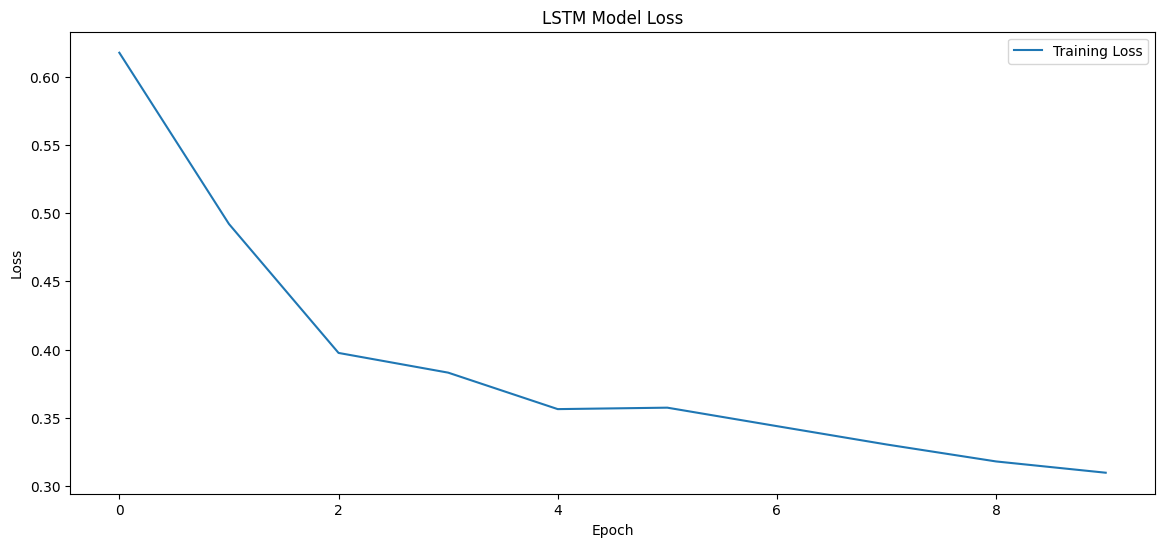

In [58]:
# Instanciando e treinando o modelo
lstm = models.LSTM((X_train.shape[1], X_train.shape[2]), int(best_model.Units))
lstm.fit(X_train, y_train)
plot_lstm_loss(lstm)

In [59]:
pred = lstm.predict(X_test).reshape(-1)
fitted = lstm.predict(X_train).reshape(-1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  


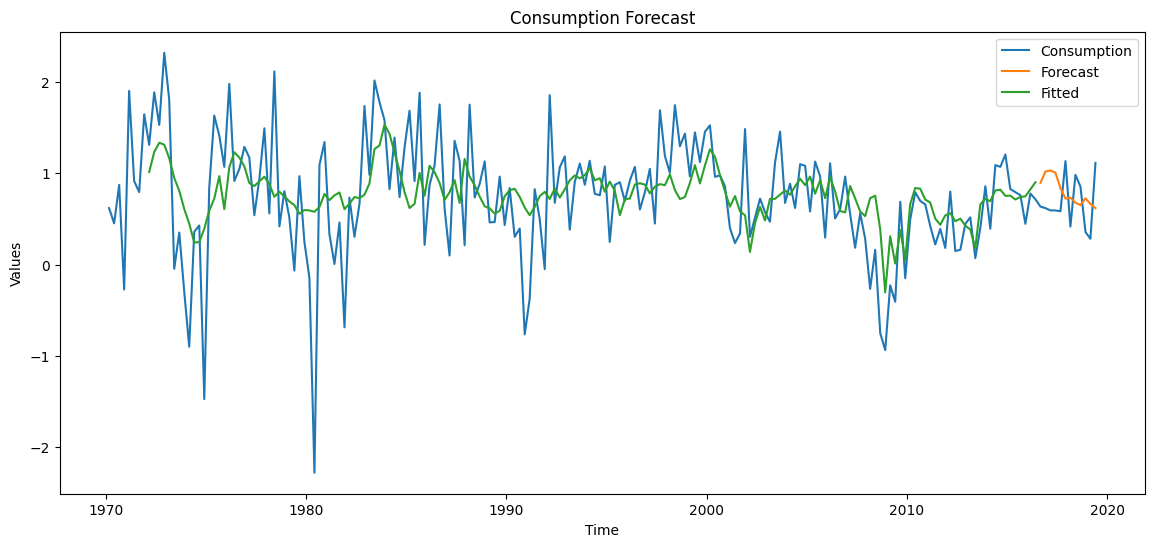

In [60]:
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(us_change['Quarter'], us_change['Consumption'], label='Consumption')
ax.plot(us_change['Quarter'].iloc[-len(pred):], pred, label='Forecast')
ax.plot(us_change['Quarter'].iloc[-len(fitted)-TEST_SIZE:-TEST_SIZE], fitted, label='Fitted')
ax.set_title('Consumption Forecast')
ax.set_xlabel('Time')
ax.set_ylabel('Values')
ax.legend()
plt.show()

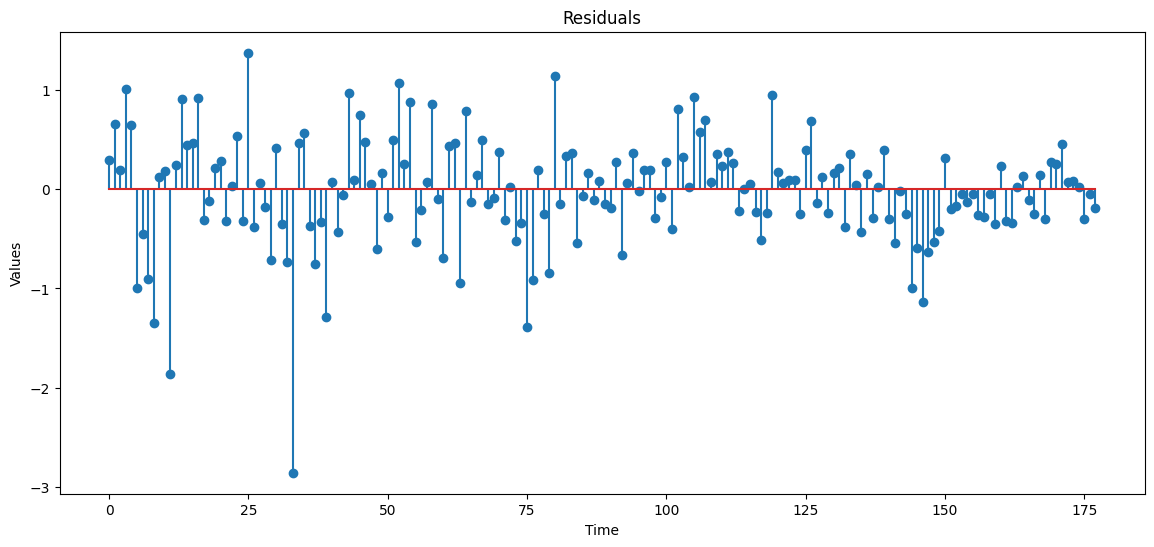

In [61]:
resid = y_train - fitted
plot_resid(resid)

In [62]:
results_cov = get_metrics(y_train, fitted, y_train, lstm.model.count_params())
results_cov

{'MAE': 0.3984857906501691,
 'MSE': 0.3007618333161931,
 'RMSE': 0.5484175720344792,
 'MAPE': 152.38004917362585,
 'SMAPE': 56.83126952382091,
 'R2': 0.2945938423938075,
 'MASE': 0.7129293143416986,
 'AIC': 137260.1442889595,
 'BIC': 355966.40018538653}

Nesse caso não iremos buscar pelos melhors hiperparâmentros, vamos utilizar os mesmos hiperparâmetros do modelo anterior.

## Melhor modelo

Após averiguar tanto modelo utilizando apenas a própria série temporal quanto modelo utilizando covariáveis, vamos escolher o melhor modelo e fazer a previsão.

In [63]:
pd.DataFrame([results, results_cov], index=['Univariate', 'Multivariate'])

,MAE,MSE,RMSE,MAPE,SMAPE,R2,MASE,AIC,BIC
Univariate,0.445228,0.365611,0.604658,130.852681,64.401827,0.142497,0.796555,133198.898963,345388.862149
Multivariate,0.398486,0.300762,0.548418,152.380049,56.831270,0.294594,0.712929,137260.144289,355966.400185


No nosso caso, o modelo que utiliza covariáveis obteve um melhor desempenho. Apesar de um AIC e BIC maiores que o univariado (devido ao aumento de parâmetros), as outras métricas de avaliação foram melhores.

Por fim, é necessário avaliarmos os resíduos do modelo escolhido para garantir que não há padrões restantes.

In [64]:
ljung_box_results = acorr_ljungbox(resid, lags=range(1, 16), return_df=True)
ljung_box_results

,lb_stat,lb_pvalue
1,2.648765,0.103630
2,3.546121,0.169812
3,11.342178,0.010012
4,11.414954,0.022276
5,11.523235,0.041938
6,12.713608,0.047816
7,13.440053,0.062085
8,15.270781,0.054089
9,15.857261,0.069923
10,15.946149,0.101184


Baseado nos `p-values` dos testes de Ljung-Box podemos rejeitar a hipótese nula de que os resíduos são independentes. Isso sugere que ainda há padrões nos resíduos. Dessa forma, o LSTM não foi capaz de capturar toda a informação presente nos dados.

## Conclusão

Após avaliar tanto modelos univariados quanto modelos multivariados, o modelo que utiliza covariáveis obteve um melhor desempenho. Apesar de um AIC e BIC maiores que o univariado (devido ao aumento de parâmetros), as outras métricas de avaliação foram melhores. Contudo, mesmo o melhor modelo obtido não foi capaz de capturar toda a informação presente nos dados, como sugere a análise dos resíduos utilizando o teste de Ljung-Box.